In [259]:
import pygor.load 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data_path = 'C:/Users/Michael Forsthofer/OneDrive - University of Sussex/BadenLab/2p-imaging/contralateral_OT_singleplane/st66/'
#data_path = 'D:/Box Sync/Imaging/240926/'

In [258]:
from scipy.signal import butter, filtfilt

def lowpass_filter(data, cutoff, fs, order=4):

    nyquist = 0.5 * fs  # Nyquist frequency is half the sampling rate
    normal_cutoff = cutoff / nyquist  # Normalize the cutoff frequency
    
    # Design the Butterworth filter
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    
    # Apply the filter to the data using filtfilt for zero-phase filtering
    filtered_data = filtfilt(b, a, data)
    
    return filtered_data

def flexible_reshape(array, columns):
    # Calculate the number of elements to keep
    elements_to_keep = (len(array) // columns) * columns
    # Reshape the array
    reshaped_array = array[:elements_to_keep].reshape(-1, columns)
    return reshaped_array

In [260]:
filename = '2024-8-27_x240827_1_1cOTs.h5'
stimtypes = ['stationary stripes','moving stripes','stationary stripes','OFF','dots_ON','OFF','ON','dots_OFF','ON', 'ON', 'loom']
stimtypes_relevant = ['moving stripes', 'dots_ON', 'dots_OFF', 'loom']
data_object = pygor.load.Core(data_path+filename)

C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_22128\238743472.py:4: UserWarning: 2024-8-27_x240827_1_1cOTs: Trigger mode 11 does not match phase number 1
  data_object = pygor.load.Core(data_path+filename)


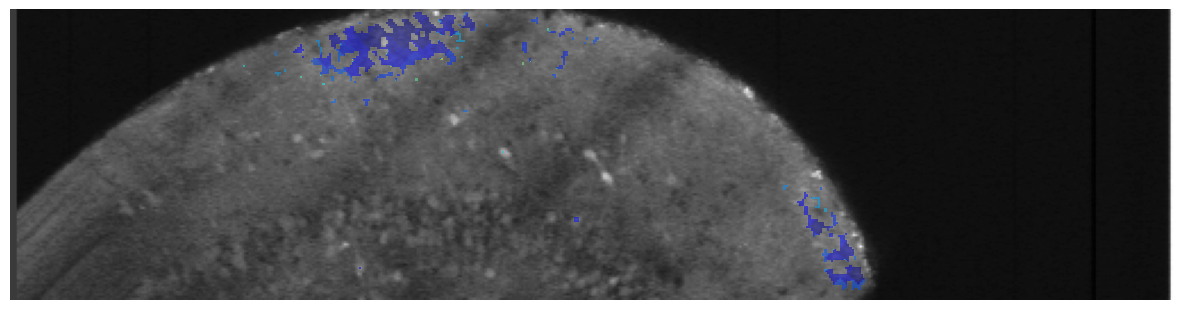

In [261]:
data_object.view_stack_rois(labels=False, figsize_scale=3, func='average_stack')

<b>Find where rois are located</b>

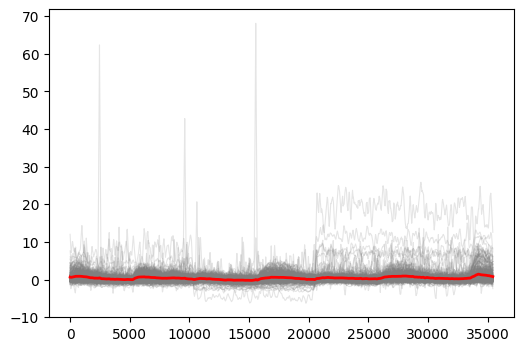

In [262]:


f1, ax1 = plt.subplots(1, 1, figsize=(6, 4))
#ax1.plot(data_object.averages.transpose(), color='grey', alpha=0.2, linewidth=0.5)



fs = 1/(data_object.frame_hz/(data_object.frame_hz/data_object.linedur_s))  # Sampling rate in Hz
cutoff = 1  # Cutoff frequency in Hz

# Apply the low-pass filter
#traces = lowpass_filter(data_object.averages, cutoff, fs)
traces = data_object.averages

plt.plot(traces.transpose(), color='grey', alpha=0.2, linewidth=0.8)
mean_roi_activity = np.mean(traces, axis=0)
plt.plot(mean_roi_activity, color='red', alpha=1, linewidth=2)



Cluster whole traces:

C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_22128\1980423844.py:30: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram(linkage(euc_distances, method="complete"), ax=ax[1], color_threshold=150)
C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_22128\1980423844.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_22128\1980423844.py:36: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage(euc_distances, method="complete"), criterion="distance", t=150


10


C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_22128\1980423844.py:44: RuntimeWarning: Mean of empty slice
  ax[i-1].plot(np.nanmean(data[clustering == i], axis=0), color='red', linewidth=3)
C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_22128\1980423844.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


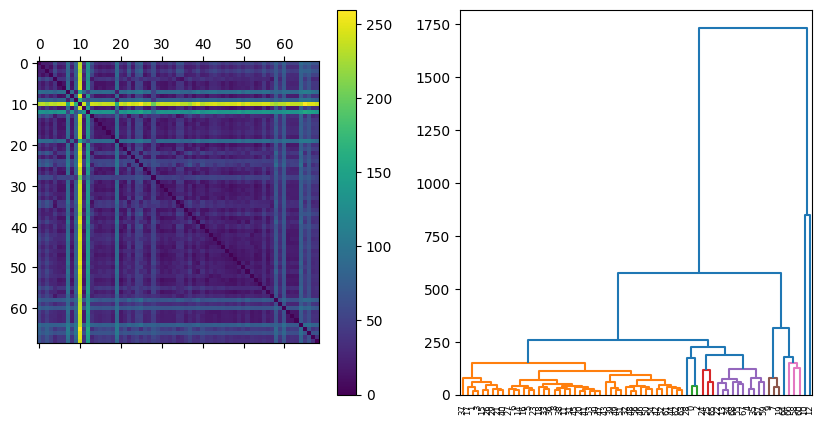

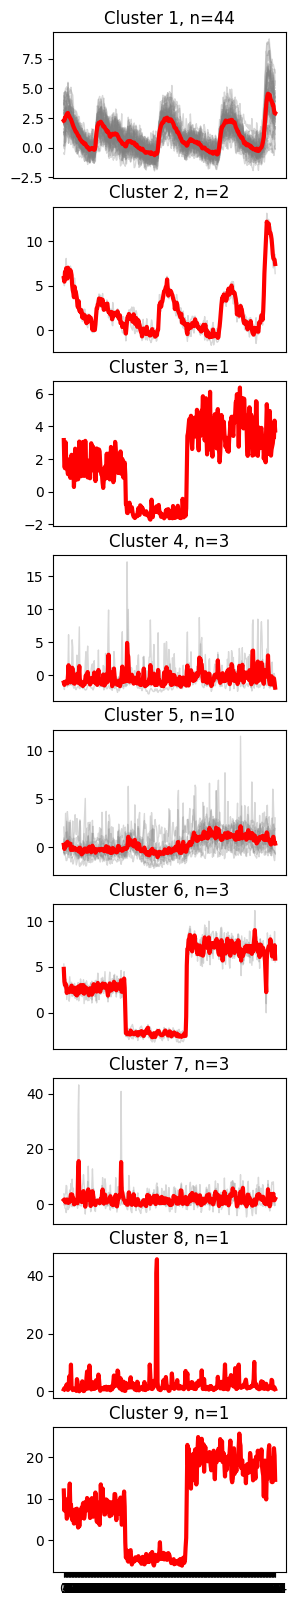

In [263]:
import numpy as np
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

lower_lim = 0.8
upper_lim = 10

downsampled_traces = data_object.averages[:,::100]

trace_means = abs(np.mean(downsampled_traces, axis=1))
trace_stds = abs(np.std(downsampled_traces, axis=1))
downsampled_traces_filtered = downsampled_traces[np.where((trace_stds<upper_lim) & (trace_stds>lower_lim)) [0],:]

# %% Load data
data = downsampled_traces_filtered

# %% Euclidean distance matrix
euc_distances = euclidean_distances(data)

# %% Visualize distance matrix
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
cax = ax[0].matshow(euc_distances)
fig.colorbar(cax)
# ax.set_xlim(100, 150)
# ax.set_ylim(100, 150)

# %% plot dendrogram with indicated threshold
dendrogram(linkage(euc_distances, method="complete"), ax=ax[1], color_threshold=150)
fig.show()

# %% Cluster data based on distance matrix

clustering = fcluster(
    linkage(euc_distances, method="complete"), criterion="distance", t=150
)
print(np.max(clustering))

# %% Plot clusters
fig, ax = plt.subplots(np.max(clustering)-1, 1, figsize=(3, 20))
for i in range(np.max(clustering)):
    ax[i-1].plot(data[clustering == i].transpose(), color='grey', alpha=0.3, linewidth=1)
    ax[i-1].plot(np.nanmean(data[clustering == i], axis=0), color='red', linewidth=3)
    ax[i-1].set_xticks([])
    ax[i-1].set_title(f"Cluster {i}, n={np.sum(clustering == i)}")
ax[-1].set_xticks(range(data.shape[1]))
fig.show()

Cluster individual stimulus responses

In [264]:
triggertimes_ms = (data_object.triggerstimes_frame-data_object.triggerstimes_frame[0])/data_object.frame_hz/data_object.linedur_s

mean_triggertimes_ms = flexible_reshape(triggertimes_ms, data_object.trigger_mode)
mean_triggertimes_ms = np.mean(mean_triggertimes_ms, axis=0)-np.mean(mean_triggertimes_ms, axis=0)[0]
mean_triggertimes_extended = np.round(np.append(mean_triggertimes_ms, len(traces.transpose()))).astype(int)
print('Triggers at ms:', mean_triggertimes_ms)

Triggers at ms: [    0.          5120.00009138  7701.33347078 10218.66684904
 15317.33360671 17984.00032097 20544.00036666 25578.66712318
 28266.66717115 30784.00054941 32362.66724425]


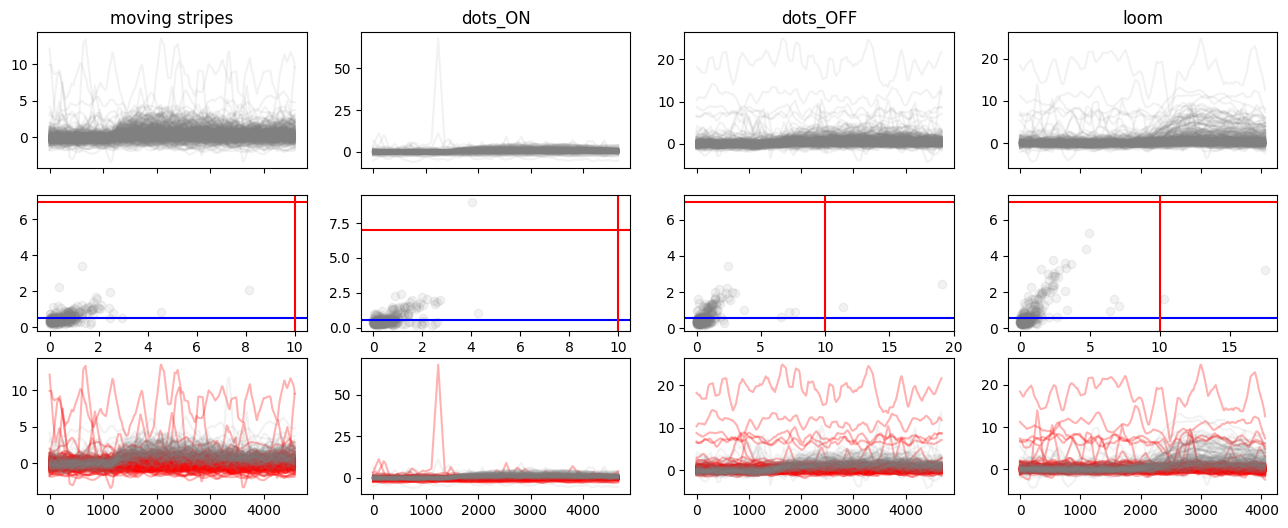

In [265]:
stim_responses = []
included_responses = []

append_idx = 1000
append_idx_post = 2000

#find stimulus segments plus some time before and after
for idx, i in enumerate(mean_triggertimes_extended[:-1]):
    if stimtypes[idx] in stimtypes_relevant:
        stim_responses.append(traces[:,i-append_idx:mean_triggertimes_extended[idx+1]+append_idx_post].transpose())  

#plot them
f, ax = plt.subplots(3, 4, figsize=(16, 6))
for idx, i in enumerate(stim_responses):
    ax[0, idx%4].plot(i, color='gray', alpha=0.1)  
    ax[0, idx%4].set_xticklabels([])
    ax[0, idx%4].set_title(stimtypes_relevant[idx])

#clean out non-responsive traces based on standard deviation filtering
responses_sorted = []
std_upper = 7
mean_lower = -1
mean_upper = 10
resting_mean_upper = 7
for idx, cur_traces in enumerate(stim_responses):
    trace_means = abs(np.mean(cur_traces, axis=0))
    trace_stds = abs(np.std(cur_traces, axis=0))
    prestim_SD = abs(np.std(cur_traces[0:1000,:], axis=0))
    std_lower = np.nanmean(prestim_SD)*1.5
    prestim_max = np.max(cur_traces[0:1000,:], axis=0)
    
#plot mean vs SD to visualize, and plot the thresholds chosen
    ax[1, idx%4].plot(trace_means, trace_stds, 'o', color='gray', alpha=0.1)
    ax[1, idx%4].axhline(y=std_upper, color='red')
    ax[1, idx%4].axhline(y=std_lower, color='blue')
    ax[1, idx%4].axvline(x=mean_upper, color='red')
    ax[2, idx%4].plot(cur_traces[:, np.where(
        (trace_stds>std_upper) | 
        (trace_stds<std_lower) | 
        (prestim_max>resting_mean_upper)) [0]], color='red', alpha=0.3)  
 
    cutouts_sorted = cur_traces[:, np.where(
        (trace_stds<std_upper) & 
        (trace_stds>std_lower) & 
        (trace_means>mean_lower) & 
        (trace_means<mean_upper) & 
        (prestim_max<resting_mean_upper)) [0]]
    ax[2, idx%4].plot(cutouts_sorted, color='gray', alpha=0.1) 

    #responses_sorted.append(cutouts_sorted[::100,:].transpose())
    responses_sorted.append(cur_traces[::100,:].transpose())
    included_responses.append(np.where(
        (trace_stds<std_upper) & 
        (trace_stds>std_lower) & 
        (trace_means>mean_lower) & 
        (trace_means<mean_upper) & 
        (prestim_max<resting_mean_upper)) [0])

C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_22128\1132483403.py:27: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  cluster_linkage = linkage(euc_distances, method="complete")
C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_22128\1132483403.py:27: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  cluster_linkage = linkage(euc_distances, method="complete")
C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_22128\1132483403.py:27: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  cluster_linkage = linkage(euc_distances, method="complete")
C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_22128\1132483403.py:27: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance m

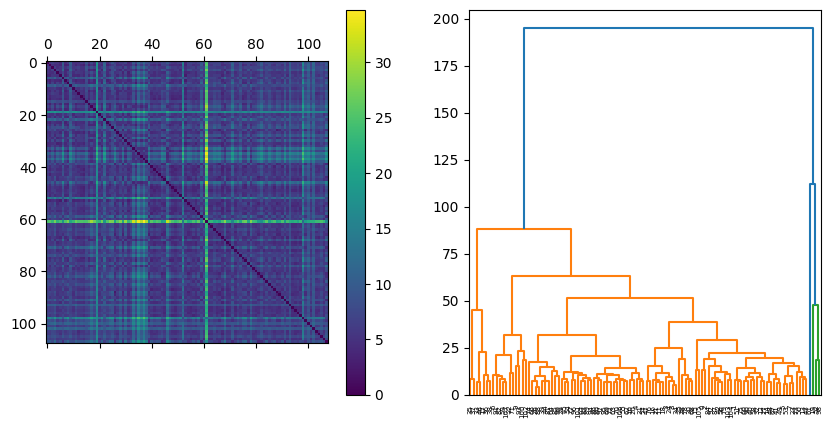

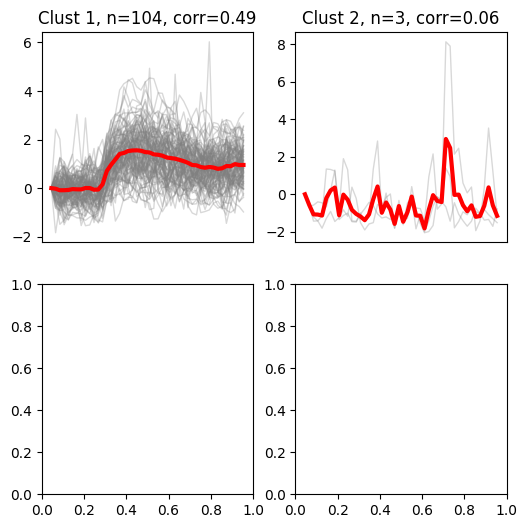

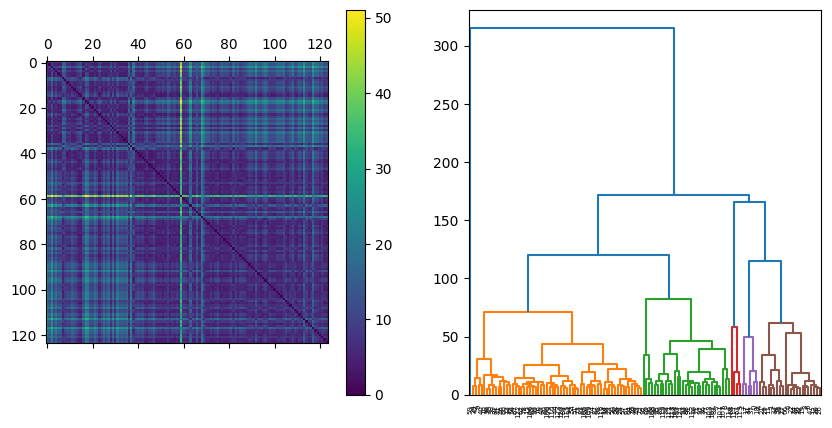

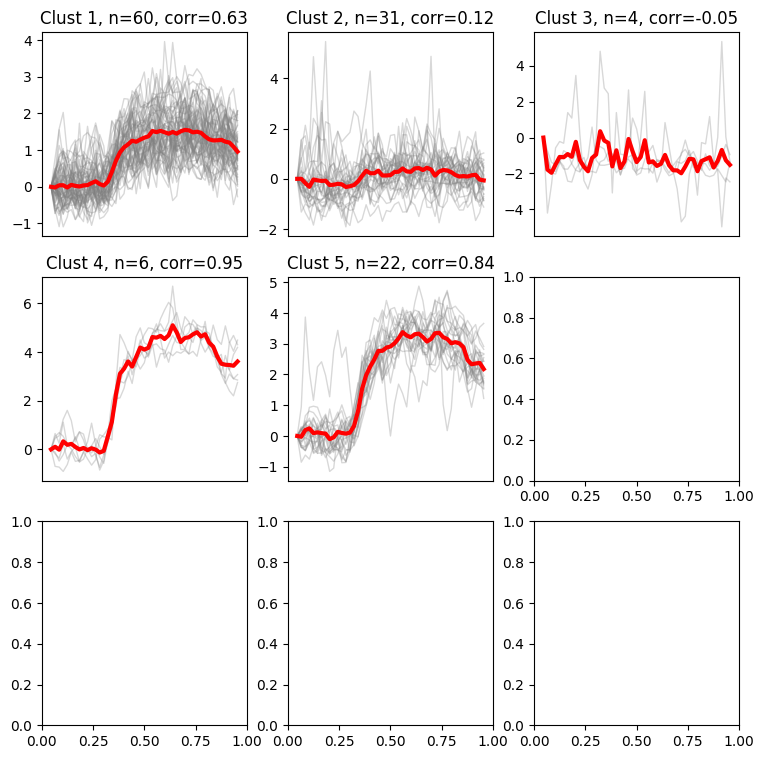

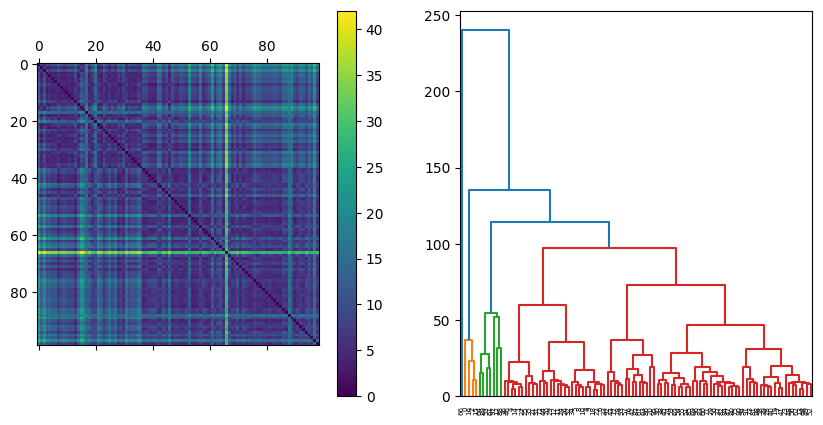

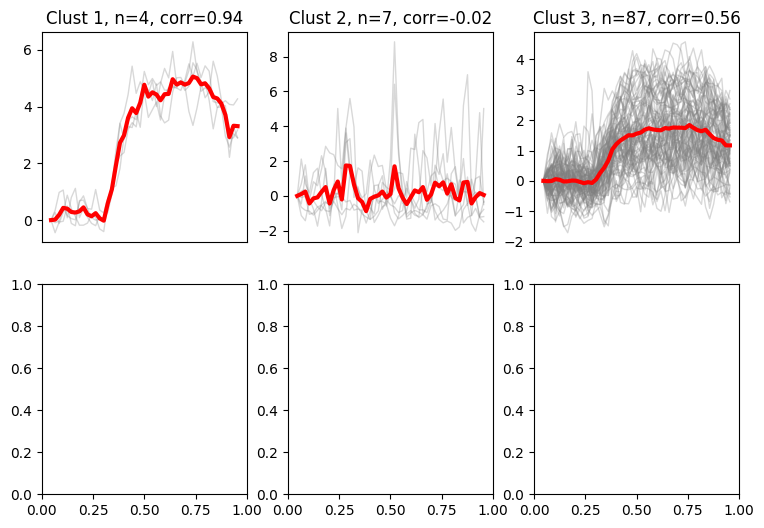

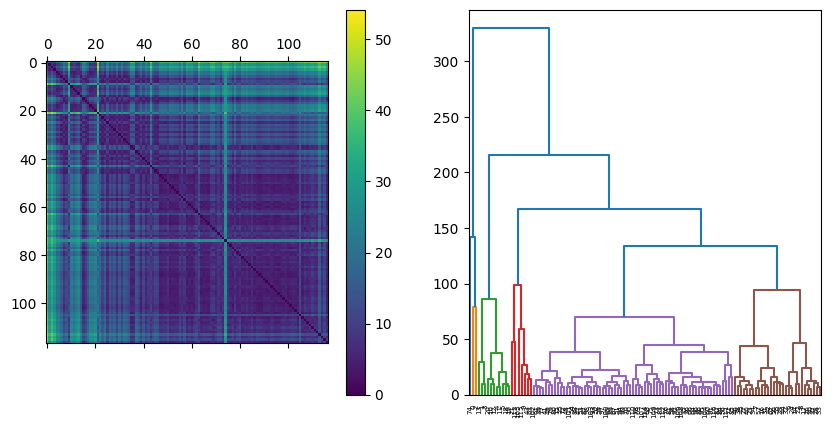

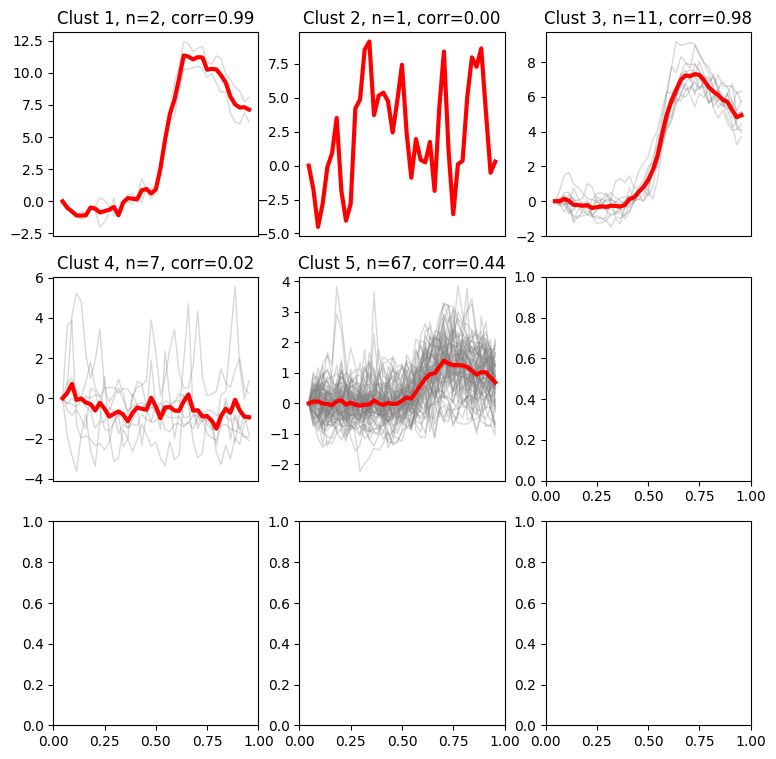

In [266]:
#to do next: z-normalize traces
#extend post-stim period 

def cluster_correlation(trace):
        if len(trace)<=1:
            average_correlation = 0 
        
        else: 
            correlation_matrix = np.corrcoef(trace.transpose(), rowvar=False)
            n = correlation_matrix.shape[0]
            upper_triangular = correlation_matrix[np.triu_indices(n, k=1)]
            average_correlation = np.mean(upper_triangular)
        return average_correlation

cluster_allocations = {}
cluster_traces = {}
cluster_correlations = {}
responding_rois = {}
for idx, cur_clust in enumerate(responses_sorted):
    cur_traces = (cur_clust[included_responses[idx],:].transpose()-cur_clust[included_responses[idx],0]).transpose()
    euc_distances = euclidean_distances(cur_traces)

    # %% Visualize distance matrix
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    cax = ax[0].matshow(euc_distances)
    fig.colorbar(cax)

    cluster_linkage = linkage(euc_distances, method="complete")
    # %% plot dendrogram with indicated threshold
    dendrogram(cluster_linkage, ax=ax[1], color_threshold=100)

    # %% Cluster data based on distance matrix
    clustering = fcluster(
        cluster_linkage, criterion="distance", t=100)

    n_clusters = np.max(clustering) + 1
    n_cols = int(np.ceil(np.sqrt(n_clusters)))
    n_rows = int(np.ceil(n_clusters / n_cols))
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    ax = ax.flatten()

    cur_clust_trace = []
    cur_clust_correlation = []
    clust_rois = []
    for i in range(1, np.max(clustering)): 
        cur_correlation = cluster_correlation(cur_traces[clustering == i])
        ax[i-1].plot(cur_traces[clustering == i].transpose(), color='grey', alpha=0.3, linewidth=1)
        ax[i-1].plot(np.nanmean(cur_traces[clustering == i], axis=0), color='red', linewidth=3)
        ax[i-1].set_xticks([])
        ax[i-1].set_title(f"Clust {i}, n={np.sum(clustering == i)}, corr={cur_correlation:.2f}" )
        cur_clust_trace.append(cur_traces[clustering == i])
        cur_clust_correlation.append(cur_correlation)
        clust_rois.append(included_responses[idx][clustering == i])
    cluster_traces[stimtypes_relevant[idx]] = cur_clust_trace
    cluster_correlations[stimtypes_relevant[idx]] = cur_clust_correlation
    responding_rois[stimtypes_relevant[idx]] = clust_rois
    

    cluster_allocations[stimtypes_relevant[idx]] = clustering

stim not in list
skipped moving stripes cluster 1, correlation too low
stim not in list
skipped dots_ON cluster 1, correlation too low
skipped dots_ON cluster 2, correlation too low
stim not in list
stim not in list
stim not in list
skipped dots_OFF cluster 1, correlation too low
stim not in list
skipped loom cluster 0, not enough traces
skipped loom cluster 1, not enough traces
stim not in list
skipped loom cluster 3, correlation too low
stim not in list


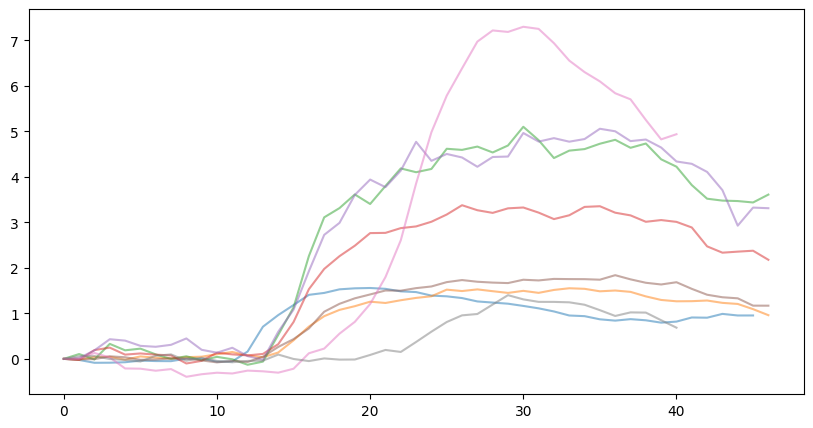

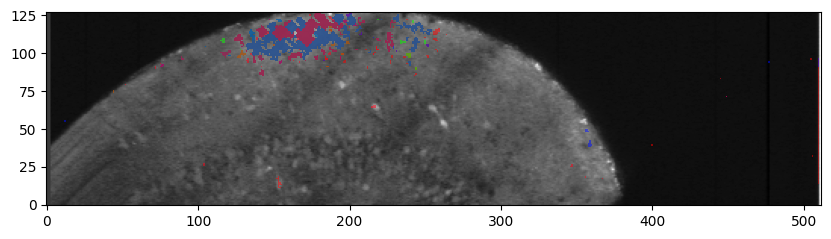

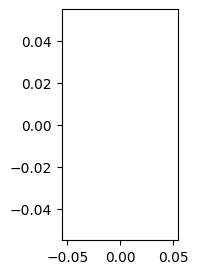

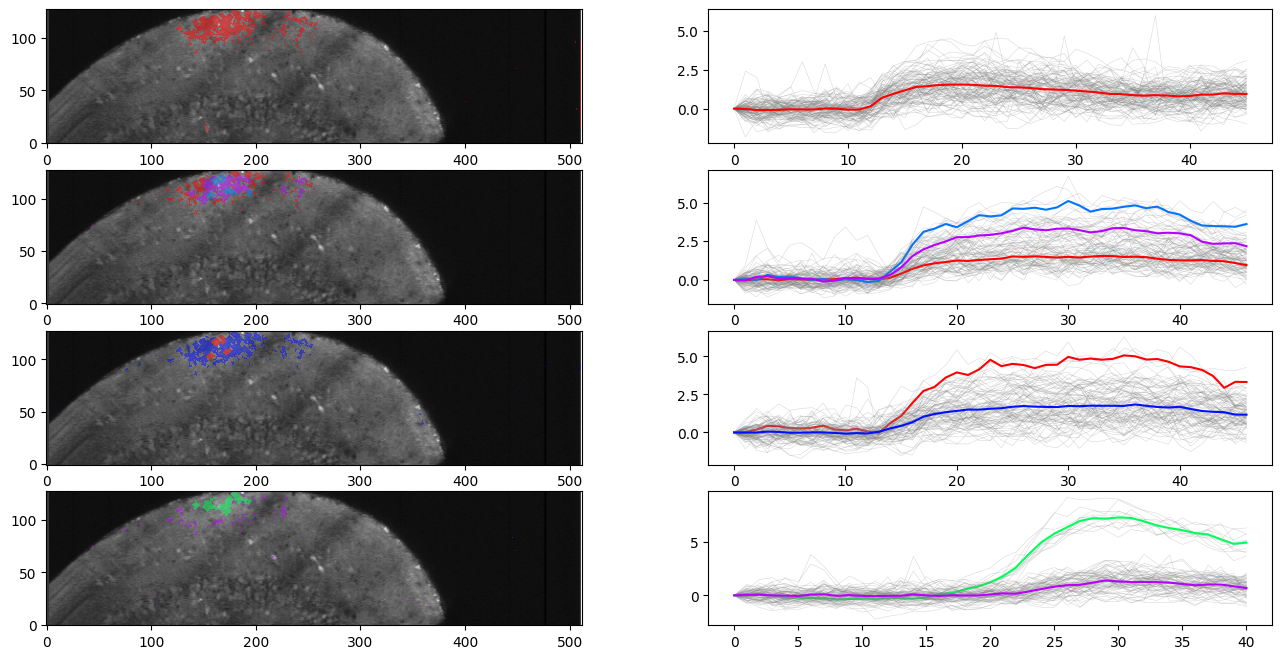

In [267]:
min_traces_per_cluster = 3
correlation_threshold = 0.25

#set up plot color parameters
stimuli_to_plot = ['moving stripes', 'dots_ON', 'dots_OFF', 'loom']
n_traces = np.zeros(len(stimuli_to_plot))
colors = plt.get_cmap('hsv')(np.linspace(0, 1, len(stimtypes_relevant)))
clustcolors = plt.get_cmap('hsv')(np.linspace(0, 1, 10))
f, ax = plt.subplots(1, 1, figsize=(10, 5))
f2, ax2 = plt.subplots(1, 1, figsize=(10, 10))
f3, ax3 = plt.subplots(1, 1, figsize=(1.5, 3))
f4, ax4 = plt.subplots(len(stimuli_to_plot), 2, figsize=(16,8))

#pre-plot the SD projection image
for background_image in range(len(stimuli_to_plot)):
    ax4[background_image, 0].imshow(data_object.average_stack, cmap="Greys_r", origin="lower")
ax2.imshow(data_object.average_stack, cmap="Greys_r", origin="lower")
handles_labels = {}
stim_responsive_clusters = []

#iterate through each stimtype and cluster
for stim_idx, cur_stim in enumerate(stimtypes_relevant):
    clustcolors = plt.get_cmap('hsv')(np.linspace(0, 1, np.max(cluster_allocations[cur_stim])))
    for idx, cur_cluster in enumerate(cluster_traces[cur_stim]):
        
        #check if cluster has enough traces
        if len(cur_cluster) < min_traces_per_cluster:
            print(f'skipped {cur_stim} cluster {idx}, not enough traces')
            continue
        
        #check if cluster has correlation above threshold
        if cluster_correlations[cur_stim][idx] <= correlation_threshold:
            print(f'skipped {cur_stim} cluster {idx}, correlation too low')
            continue

        found_rois = (responding_rois[cur_stim][idx]+1)*-1
        #found_rois = (np.where(cluster_allocations[cur_stim] == idx+1)[0]) * -1
        mask = np.isin(data_object.rois, found_rois)
        ax.plot(np.nanmean(cur_cluster, axis=0), alpha=0.5)

                         # Create a colored overlay where only the mask part is colored
        color = colors[stim_idx]  # Select the color for the current idx_stim
        clustcolor=clustcolors[idx]
        colored_mask = np.zeros((*mask.shape, 4))  # Create an RGBA image (shape + 4 for RGBA)
        clust_mask = np.zeros((*mask.shape, 4))
        if stim_idx not in handles_labels:
            ax3.plot(0, 0, color=color, label=stimtypes_relevant[stim_idx])
            handles_labels[stim_idx] = f'Stim {stim_idx}'  # Track the label
                        
        # Apply color only to the ROI parts of the mask
        colored_mask[mask] = np.array([*color[:3], 0.5])  # Use the RGB values from the colormap and set alpha to 0.5
        clust_mask[mask] = np.array([*clustcolor[:3], 0.5])  # Use the RGB values from the colormap and set alpha to 0.5

        # Plot the colored mask over the background
        ax2.imshow(colored_mask, interpolation='none', origin="lower")
        try:
            index_of_dots_ON = stimuli_to_plot.index(stimtypes_relevant[stim_idx])
            ax4[index_of_dots_ON, 0].imshow(clust_mask, interpolation='none', origin="lower")
            ax4[index_of_dots_ON, 1].plot(cur_cluster.transpose(), color='grey', alpha=0.3, linewidth=0.4)
            ax4[index_of_dots_ON, 1].plot(np.nanmean(cur_cluster, axis=0), color=clustcolor, linewidth=1.5)
                            #ax4[index_of_dots_ON, 1].set_ylim([-6, 15])
                            #ax4[index_of_dots_ON, 1].set_xlim([0, 2600])
            n_traces[index_of_dots_ON] = n_traces[index_of_dots_ON] + len(stim_responses[idx_stim][cur_label_array == cur_label,:].transpose())
        except:
            print('stim not in list')
                        
# ax2.axis('off')
# ax3.axis('off')
# ax4[0,0].axis('off')
# #ax4[0,1].axis('off')
# ax4[1,0].axis('off')
# #ax4[1,1].axis('off')
# ax4[2,0].axis('off')
# #ax4[2,1].axis('off')
# f4.tight_layout()
# # Make the legend take up the whole figure
# ax3.legend(loc='center', bbox_to_anchor=(0.5, 0.5), fontsize=12, ncol=1, frameon=False)

# f4.savefig('roiclusters.svg')

